In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

#### Load data

In [2]:
adata = sc.read_10x_h5('Donor1_filtered_feature_bc_matrix.h5')

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
adata.var_names_make_unique()
adata 

AnnData object with n_obs × n_vars = 12185 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

In [4]:
sc.pp.filter_genes(adata, min_cells=3) # remove genes not detected in atleast 3 cells

In [5]:
adata

AnnData object with n_obs × n_vars = 12185 × 21851
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [6]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 21940966 stored elements and shape (12185, 21851)>

#### Doublet detection

In [7]:
import scvi

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# feature selection to reduce training time 

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,      
    flavor='seurat_v3',
    subset=True             # subset adata to HVGs
)

In [9]:
adata

AnnData object with n_obs × n_vars = 12185 × 2000
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [10]:
scvi.model.SCVI.setup_anndata(adata)
model = scvi.model.SCVI(adata)
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [44:02<00:00,  4.70s/it, v_num=1, train_loss_step=493, train_loss_epoch=471]  

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [44:02<00:00,  6.61s/it, v_num=1, train_loss_step=493, train_loss_epoch=471]


In [11]:
solo = scvi.external.SOLO.from_scvi_model(model)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 218/400:  55%|█████▍    | 218/400 [10:10<08:29,  2.80s/it, v_num=1, train_loss_step=0.0517, train_loss_epoch=0.27] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.243. Signaling Trainer to stop.


In [12]:
df = solo.predict() # returns P(cell is a singlet) and P(cell is a doublet)
df['prediction'] = solo.predict(soft = False) # also add prediction class labels
df.head(3)

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\torch\utils\_contextlib.py:120: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\torch\utils\_contextlib.py:120: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction
AAACCCAAGCCTCTGG-1,0.685745,0.314255,doublet
AAACCCAAGCGACTTT-1,0.097449,0.902551,singlet
AAACCCAAGCGTATGG-1,0.038068,0.961932,singlet


In [16]:
df["revised_prediction"] = df.apply(
    lambda row: "doublet" if row["doublet"] > 0.8 else "singlet", axis=1
)

In [18]:
df.to_pickle("donor1_solo_out.pkl")

In [ ]:
# df = pd.read_pickle("donor1_solo_out.pkl")

#### Reload adata

In [104]:
# Because we reduced adata to only the top highly variable genes (HVGs) before training scVI
adata = sc.read_10x_h5('Donor1_filtered_feature_bc_matrix.h5') 

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [105]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 12185 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

In [106]:
adata.obs["revised_prediction"] = df["revised_prediction"]
adata.obs.head(3)

,revised_prediction
AAACCCAAGCCTCTGG-1,singlet
AAACCCAAGCGACTTT-1,singlet
AAACCCAAGCGTATGG-1,singlet


#### Calculate Quality Control Covariates

In [107]:
# define mitochondrial and ribosomal genes

adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

adata.var.head(3)

,gene_ids,feature_types,genome,mt,ribo
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,False
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,False
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,False


In [108]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=False, percent_top=None
)

In [32]:
adata.obs.head(3)

,revised_prediction,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
AAACCCAAGCCTCTGG-1,singlet,4154,17016.0,1216.0,7.146215,2261.0,13.287494
AAACCCAAGCGACTTT-1,singlet,865,1536.0,156.0,10.156250,103.0,6.705729
AAACCCAAGCGTATGG-1,singlet,383,573.0,43.0,7.504364,54.0,9.424084


In [109]:
counts = adata.obs["revised_prediction"].value_counts().reset_index()
counts

,revised_prediction,count
0,singlet,11358
1,doublet,827


In [110]:
adata = adata[adata.obs["revised_prediction"] != "doublet"].copy()

In [111]:
adata

AnnData object with n_obs × n_vars = 11358 × 33538
    obs: 'revised_prediction', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

#### Preprocessing - Quality Control

- **n_genes_by_counts** — Number of genes expressed in the count matrix.  
- **total_counts** — Total counts per cell.  
- **pct_counts_mt** — Percentage of counts in mitochondrial genes.  


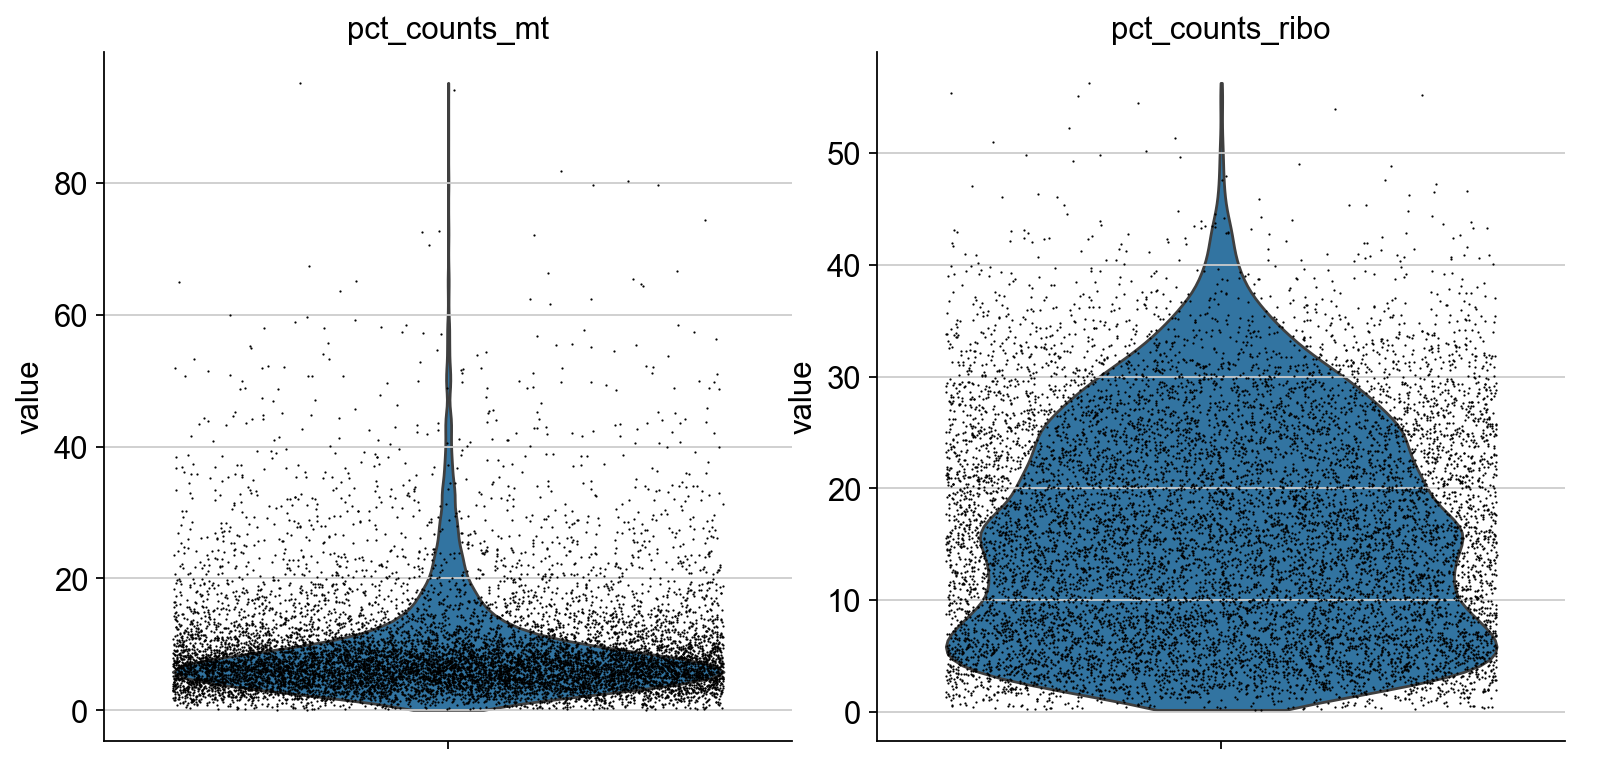

In [112]:
sc.pl.violin(
    adata,
    ["pct_counts_mt", "pct_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
)

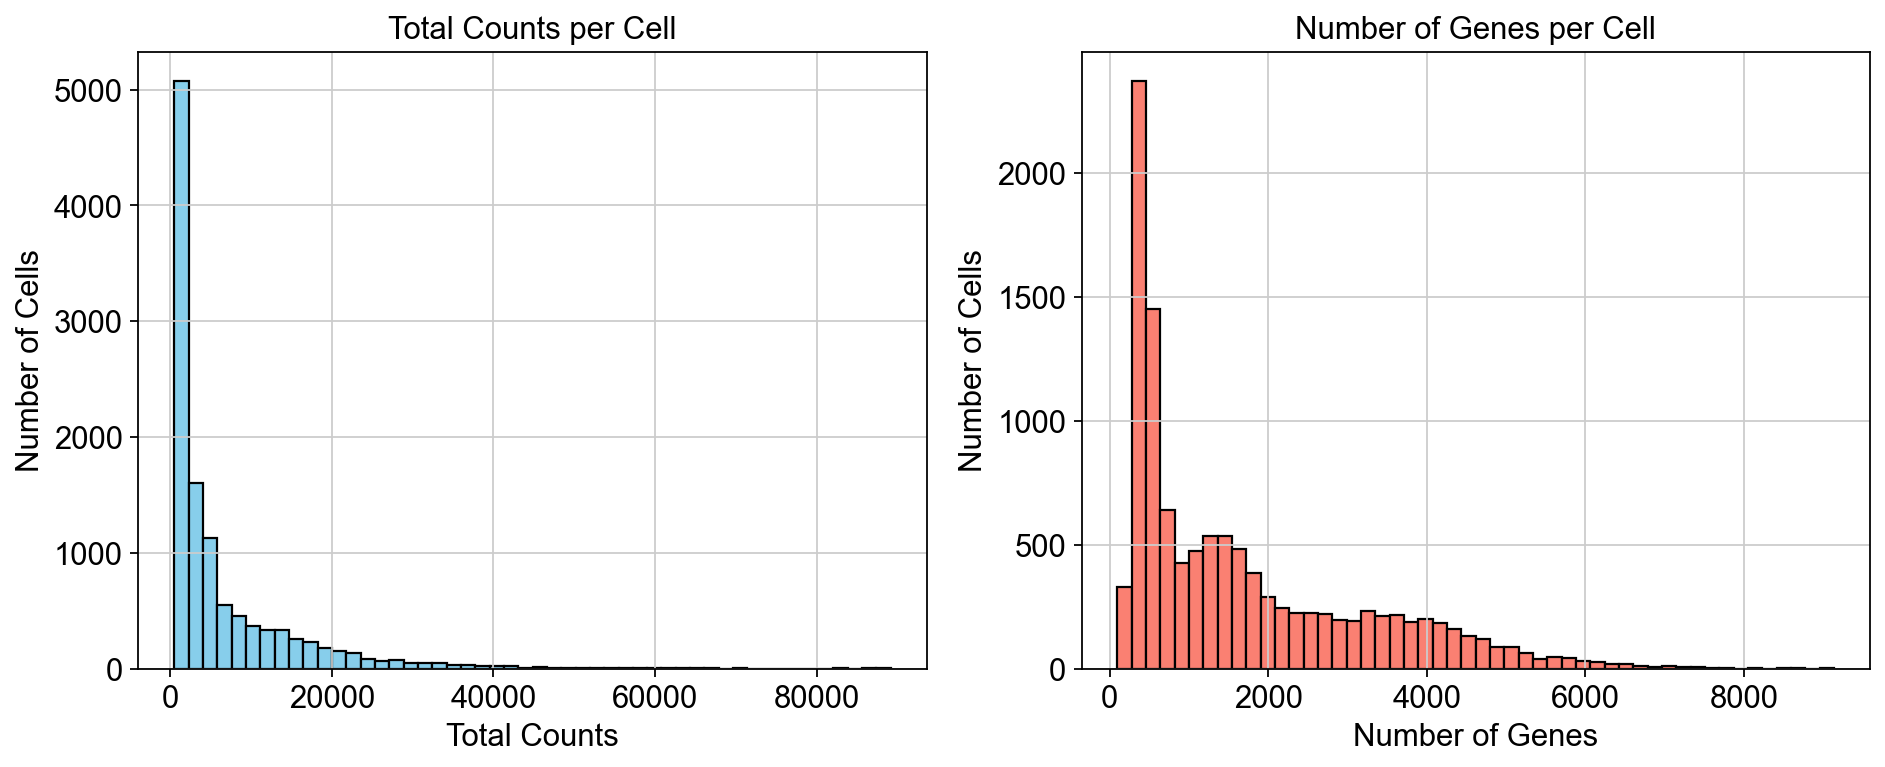

In [113]:

total_counts = adata.obs['total_counts']
n_genes = adata.obs['n_genes_by_counts']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(total_counts, bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Total Counts per Cell')
axes[0].set_xlabel('Total Counts')
axes[0].set_ylabel('Number of Cells')

axes[1].hist(n_genes, bins=50, color='salmon', edgecolor='black')
axes[1].set_title('Number of Genes per Cell')
axes[1].set_xlabel('Number of Genes')
axes[1].set_ylabel('Number of Cells')

plt.tight_layout()
plt.show()


In [114]:
adata.obs.sort_values(by='n_genes_by_counts', ascending=True).head(3)

,revised_prediction,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
GCGGATCTCGGACAAG-1,singlet,96,513.0,9.0,1.754386,22.0,4.288499
TGATCAGCAGTCCGTG-1,singlet,103,574.0,78.0,13.588850,21.0,3.658536
AGGACTTTCTTCACAT-1,singlet,103,703.0,31.0,4.409673,19.0,2.702703


In [115]:
adata.obs.sort_values(by='total_counts', ascending=True).head(3)

,revised_prediction,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TCGAAGTAGTCACTGT-1,singlet,331,500.0,51.0,10.200000,106.0,21.199999
TGACTCCCATCATCTT-1,singlet,330,500.0,78.0,15.600000,40.0,8.000000
AGGTCTAAGCCTCTCT-1,singlet,284,500.0,96.0,19.200001,32.0,6.400000


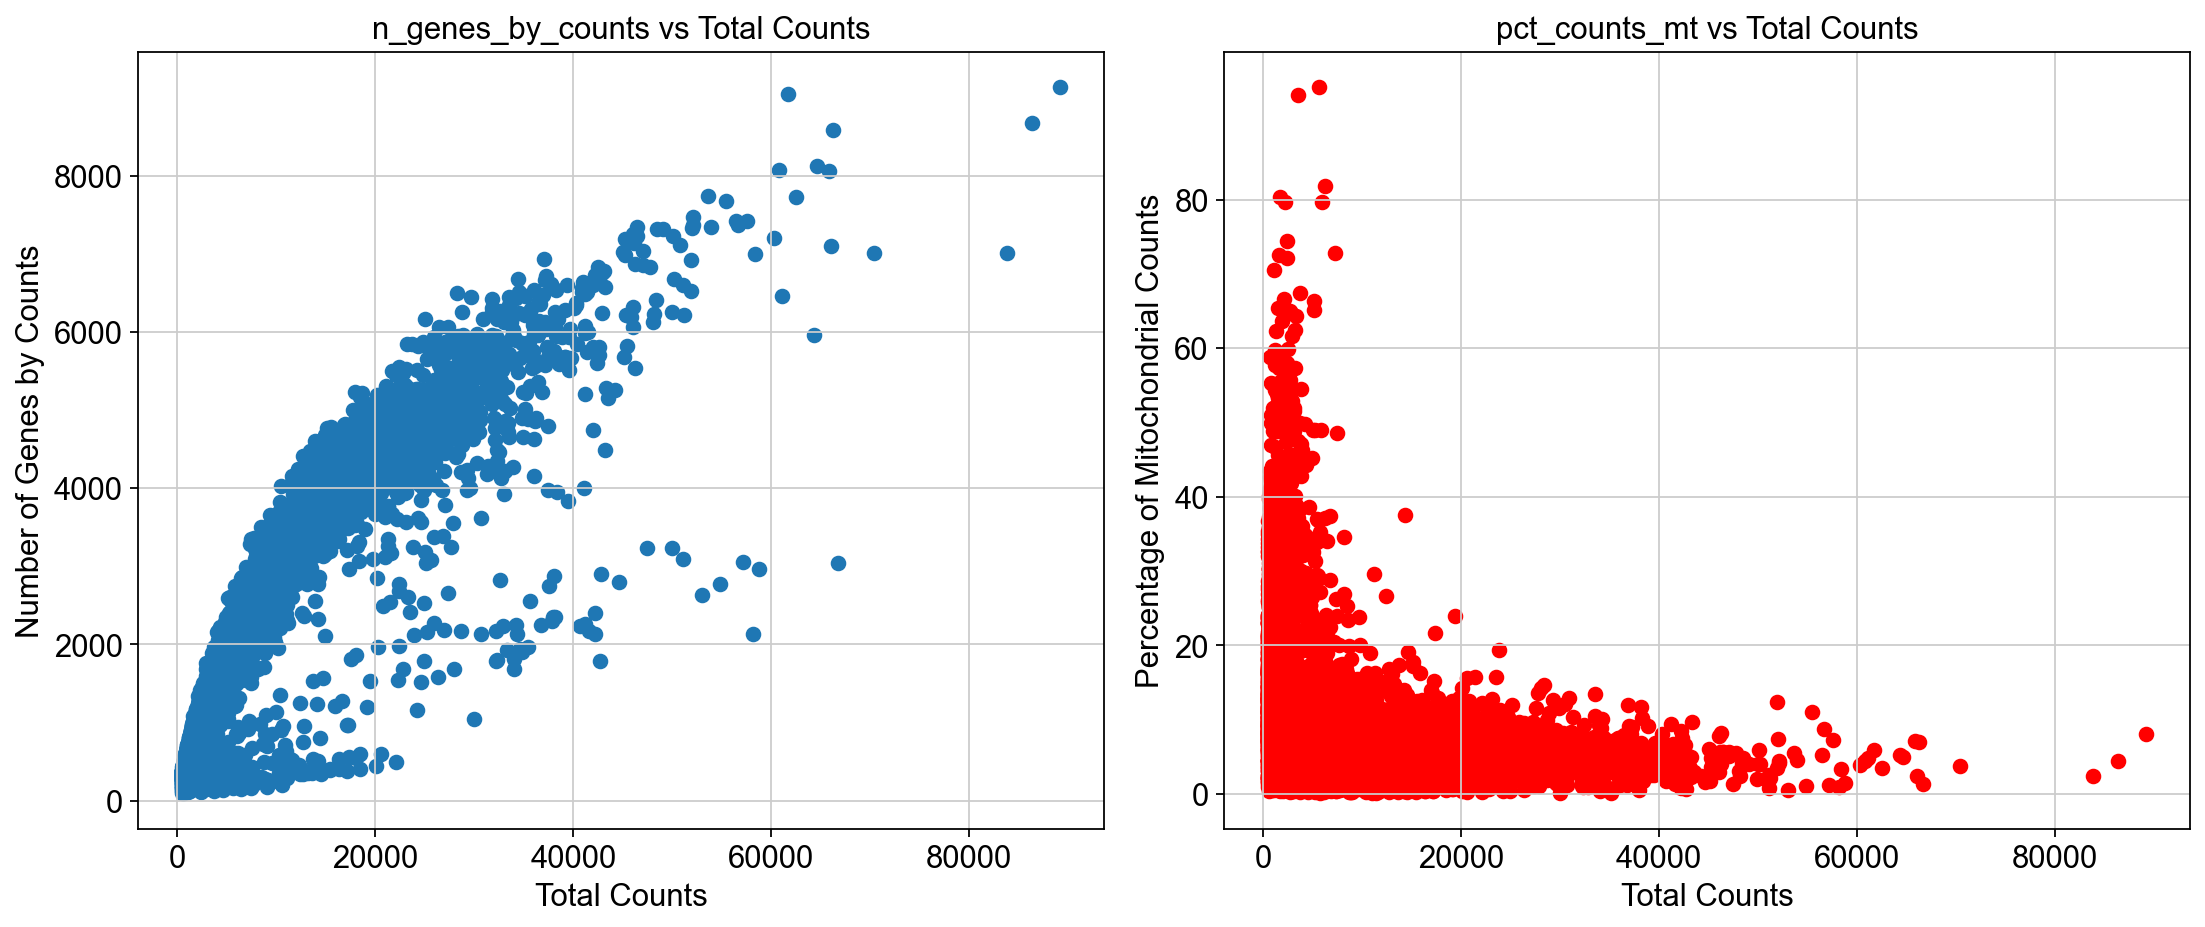

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'])
axes[0].set_xlabel('Total Counts')
axes[0].set_ylabel('Number of Genes by Counts')
axes[0].set_title('n_genes_by_counts vs Total Counts')

axes[1].scatter(adata.obs['total_counts'], adata.obs['pct_counts_mt'], color='red')
axes[1].set_xlabel('Total Counts')
axes[1].set_ylabel('Percentage of Mitochondrial Counts')
axes[1].set_title('pct_counts_mt vs Total Counts')

plt.tight_layout()
plt.show()

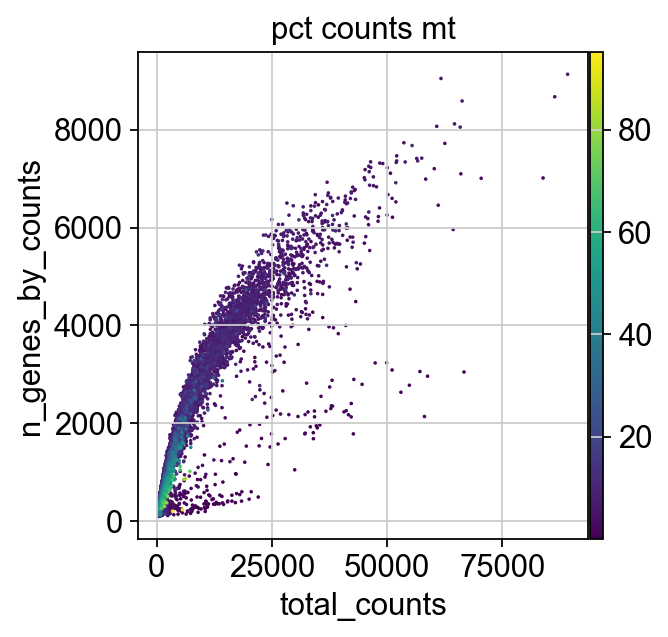

In [117]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [118]:
sc.pp.filter_genes(adata, min_cells=3) 

In [122]:
def is_outlier(adata, metric: str, lower_q=0.01, upper_q=0.99):
    """Return boolean Series marking cells outside the given quantile range."""
    M = adata.obs[metric]
    lower = M.quantile(lower_q)
    upper = M.quantile(upper_q)
    outlier = (M < lower) | (M > upper)
    return outlier

In [123]:
adata.obs["outlier"] = (
    is_outlier(adata, "total_counts")
    | is_outlier(adata, "n_genes_by_counts")
)
adata.obs.outlier.value_counts()

outlier
False    10985
True       373
Name: count, dtype: int64

In [124]:
adata = adata[(~adata.obs.outlier)]

In [125]:
print(f"Mito percent > 20: {(adata.obs["pct_counts_mt"] > 20).sum()}")
print(f"Ribo percent > 20: {(adata.obs["pct_counts_ribo"] > 20).sum()}") # could be due to poor mRNA capture

Mito percent > 20: 883
Ribo percent > 20: 3805


In [126]:
adata = adata[adata.obs.pct_counts_mt < 20]
adata = adata[adata.obs.pct_counts_ribo < 20]

In [127]:
adata

View of AnnData object with n_obs × n_vars = 6301 × 21528
    obs: 'revised_prediction', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

#### Normalization

In [128]:
sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI
sc.pp.log1p(adata)

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [129]:
adata_copy = adata.copy()

In [130]:
adata_copy

AnnData object with n_obs × n_vars = 6301 × 21528
    obs: 'revised_prediction', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'

#### Feature selection

In [131]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
adata.var.head(3) # new column - highly_variable 

,gene_ids,feature_types,genome,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,False,16,0.001395,99.868691,17.0,12,True,0.008633,3.111803,1.941229
AL669831.5,ENSG00000237491,Gene Expression,GRCh38,False,False,216,0.019040,98.227329,232.0,178,False,0.025680,1.731000,0.221413
FAM87B,ENSG00000177757,Gene Expression,GRCh38,False,False,13,0.001149,99.893311,14.0,11,False,0.000593,-0.141266,-2.110528


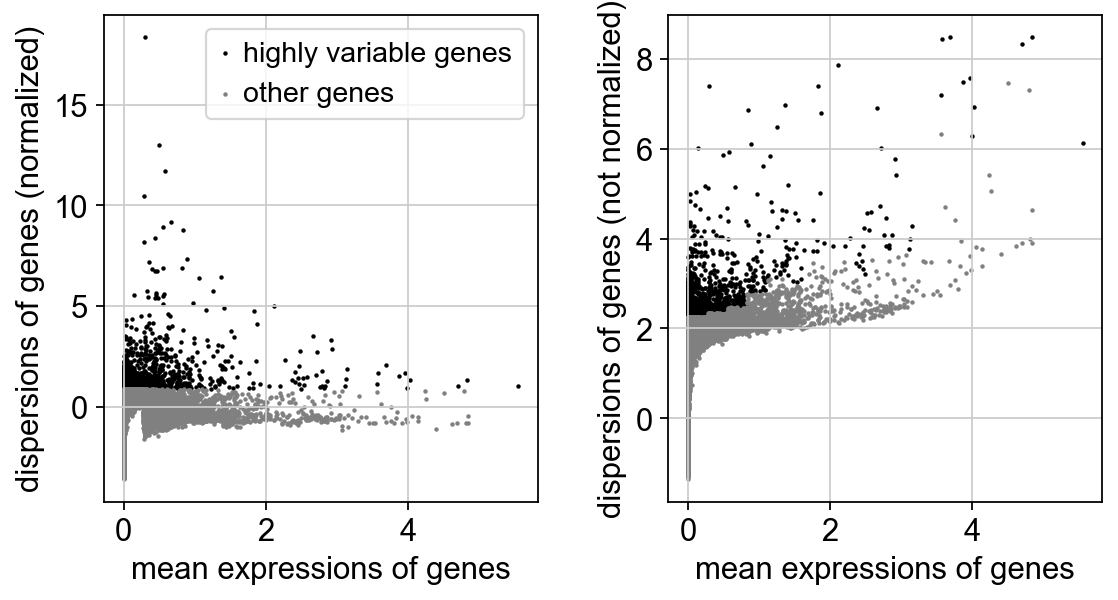

In [132]:
sc.pl.highly_variable_genes(adata)

#### Dimensionality reduction and clustering

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\scanpy\preprocessing\_pca\__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


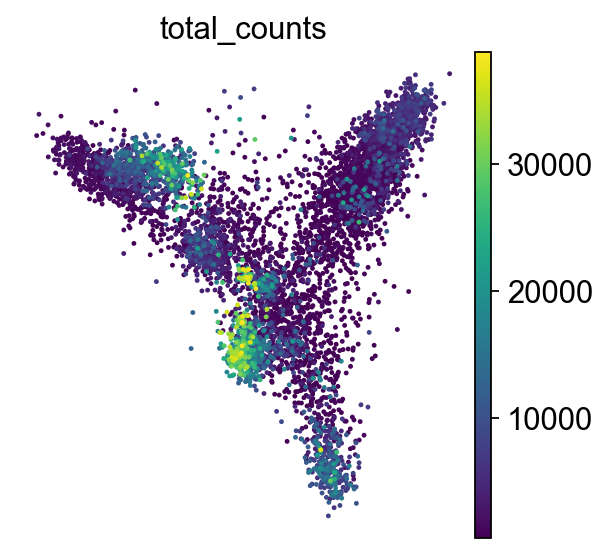

In [133]:
sc.pp.pca(adata, use_highly_variable=True)

sc.pl.pca_scatter(adata, color="total_counts")

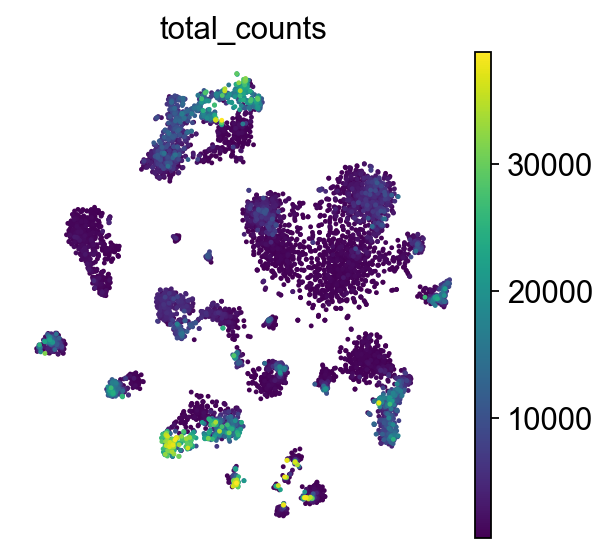

In [134]:
sc.tl.tsne(adata)
sc.pl.tsne(adata, color="total_counts")

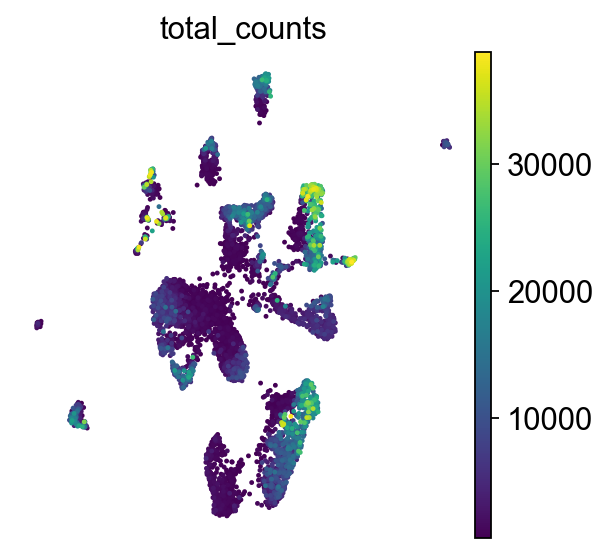

In [135]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(adata, color="total_counts")

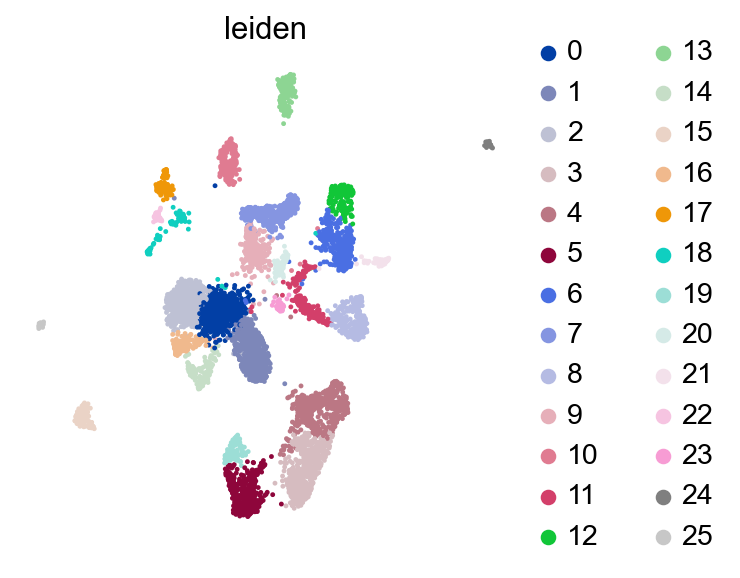

In [136]:
sc.tl.leiden(adata)

sc.pl.umap(adata, color=["leiden"])

#### without feature selection

In [139]:
adata_copy.var.head(1) # no highly_variable column

,gene_ids,feature_types,genome,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,False,16,0.001395,99.868691,17.0,12


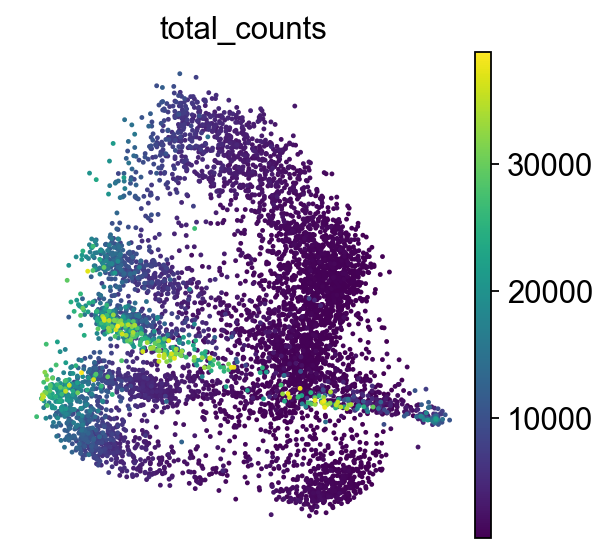

In [141]:
sc.pp.pca(adata_copy)
sc.pl.pca_scatter(adata_copy, color="total_counts")

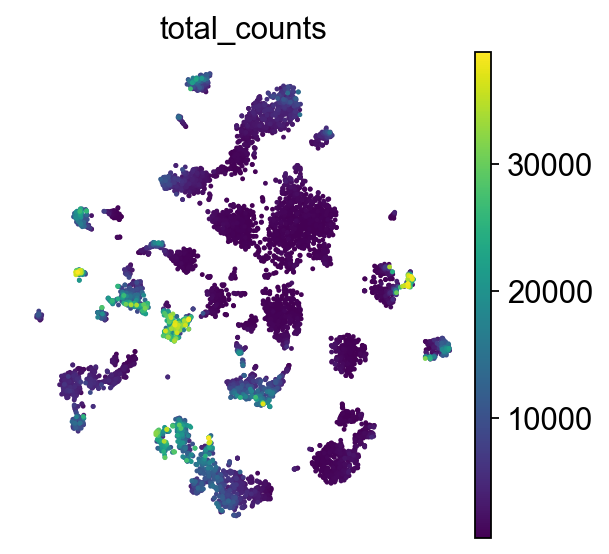

In [142]:
sc.tl.tsne(adata_copy)
sc.pl.tsne(adata_copy, color="total_counts")

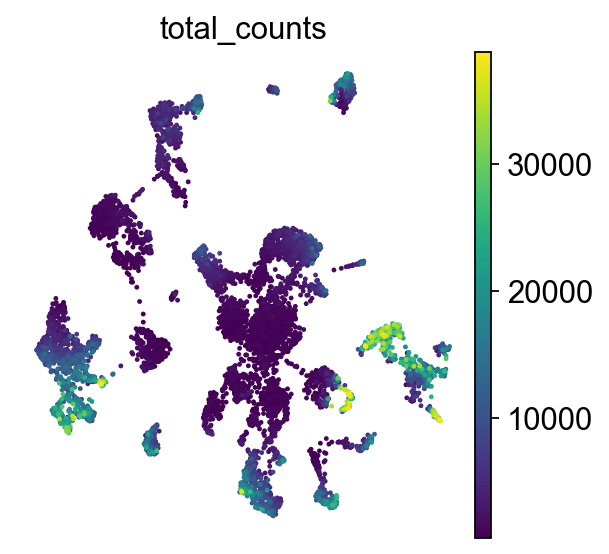

In [143]:
sc.pp.neighbors(adata_copy)
sc.tl.umap(adata_copy)
sc.pl.umap(adata_copy, color="total_counts")

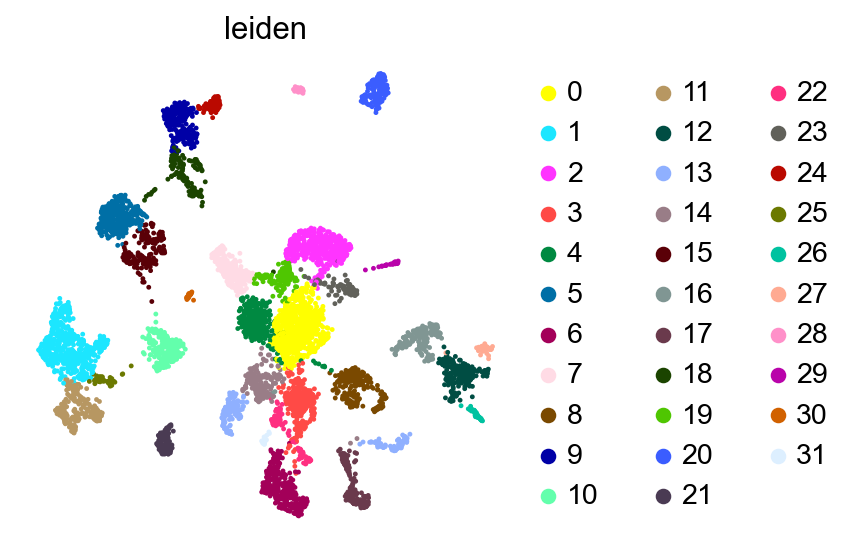

In [144]:
sc.tl.leiden(adata_copy)
sc.pl.umap(adata_copy, color=["leiden"])

In [ ]:
# adata.write("adata.h5ad")
# adata = sc.read_h5ad("adata.h5ad")